#  Step 1: Generate Gaussian input data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define number of bins (Cannot be less than 5 due to kernel size)
nbins = 28

# define function to generate gaussian background: 
def generate_background_hist(num_points=1000):
    # Generate random 2D Gaussian data as shown in the previous answers
    mu_x = 0.5
    mu_y = 0.5
    sigma_x = 0.1
    sigma_y = 0.1

    data = np.random.multivariate_normal([mu_x, mu_y], [[0.01, 0.], [0., 0.01]], num_points)
    
    # Create a 2D histogram with specified limits
    hist, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=(nbins, nbins), range=[[0, 1], [0, 1]])
    hist_normalized = hist / hist.sum()
    
    return hist_normalized

# define function to generate signal:
def generate_signal_hist(num_points=1000):
    # first naive starting point: empty histogram
    # return np.zeros((nbins, nbins))
    
    # Generate random 2D Gaussian data as shown in the previous answers
    mu_x = 0.5
    mu_y = 0.5
    sigma_x = 0.1
    sigma_y = 0.1

    # data = np.random.normal([mu_x, mu_y], [sigma_x, sigma_y], (num_points, 2))
    gaussian_data = np.random.multivariate_normal([mu_x, mu_y], [[0.01, 0.], [0.0, 0.01]], num_points)
    
    # Generate random angles and radii
    theta = np.linspace(0, np.random.uniform(0., 3) * np.pi, num_points)
    radius = np.linspace(0.1, np.random.uniform(0.2, 0.6), num_points)

    # Convert polar coordinates to Cartesian coordinates
    x = radius * np.cos(theta) + 0.5 + np.random.uniform(-0.1, 0.1, num_points)
    y = radius * np.sin(theta) + 0.5 + np.random.uniform(-0.1, 0.1, num_points)

    # Add the spiral features to the Gaussian data
    inflow = np.column_stack((x, y))
    data = np.concatenate( (gaussian_data, inflow), axis=0)
    # data = np.column_stack((x, y))
    # print(data.shape, gaussian_data.shape, inflow.shape)
    
    hist, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=(nbins, nbins), range=[[0, 1], [0, 1]])
    hist_normalized = hist / hist.sum()
    
    return hist_normalized


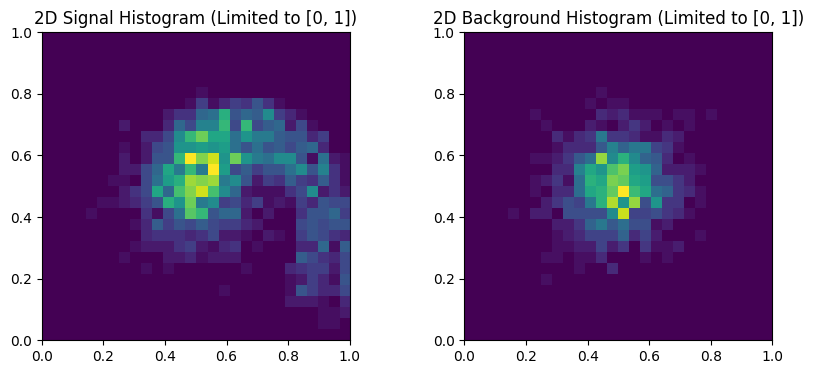

In [30]:
# Plot the histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.imshow(generate_signal_hist(), extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
ax1.set_title('2D Signal Histogram (Limited to [0, 1])')

ax2.imshow(generate_background_hist(), extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
ax2.set_title('2D Background Histogram (Limited to [0, 1])')

# Display the plot
plt.show()

##  Make batch of training data

In [3]:
import torch
def make_batch(N = 300, collection = 'train'):
    images = np.zeros((N, nbins, nbins))
    labels = np.zeros((N))
    # Make Background data with label 0
    for i in range(N):
        # Make Background data with label 0
        if i < N/2:
            images[i] = np.array(generate_background_hist())
            labels[i] = np.array([0])
        # Make Signal data with label 1
        else:
            images[i] = np.array(generate_signal_hist())
            labels[i] = np.array([1])
    
    # Rescale images?
    
    # Shuffle indices:
    indices = np.random.permutation(N)
    # # indices = np.random.choice(np.arange(len(images)), size = (N,), replace = True)
    X = images[indices]
    y = labels[indices]
    return torch.FloatTensor(X.reshape(-1,nbins**2)), torch.FloatTensor(y.reshape(-1, 1))

X, y = make_batch(N=10)
X.shape, y.shape, y

(torch.Size([10, 784]),
 torch.Size([10, 1]),
 tensor([[1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.]]))

# Step 2: Define & Train CNN/MLP

In [4]:
import torch

def create_cnn():
    return torch.nn.Sequential(
        torch.nn.Unflatten(-1,(1,nbins,nbins)),
        torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2),
        torch.nn.Flatten(),
        # torch.nn.Linear(2592,10),# for MNIST classification, here binary
        torch.nn.Linear(512,1),
        torch.nn.Sigmoid(),
)

model = create_cnn()
print(model(torch.randn(123,nbins**2)).shape)

torch.Size([123, 1])


In [5]:
def eval_model(model, collection):
    X,y = make_batch(N = 200, collection=collection)
    p = model(X)
    # loss = torch.nn.functional.cross_entropy(p,y)
    loss = torch.nn.functional.binary_cross_entropy(p,y)
    return loss

def train(model_fn, Nsteps = 200):
    trajectory = []
    model = model_fn()
    optim = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(Nsteps):
        
        loss = eval_model(model,'train')
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        with torch.no_grad():
            loss_val = eval_model(model,'test')
        trajectory.append([float(loss),float(loss_val)])
        if i % 100 == 0:
            print(f'loss: {i}: {loss:.4f}')
    return model,np.array(trajectory)

# trained_cnn,traj_cnn = train(create_cnn, Nsteps = 1001)
trained_cnn,traj_cnn = train(create_cnn, Nsteps = 301)

loss: 0: 0.6932
loss: 100: 0.0789
loss: 200: 0.0104
loss: 300: 0.0053


In [6]:
def create_mlp():
    return torch.nn.Sequential(
        torch.nn.Linear(nbins**2,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,200),
        torch.nn.ReLU(),
        # torch.nn.Linear(200,10),
        torch.nn.Linear(200,1),
        torch.nn.Sigmoid(),
)

# trained_mlp,traj_mlp = train(create_mlp, Nsteps = 1001)
trained_mlp,traj_mlp = train(create_mlp, Nsteps = 301)

loss: 0: 0.6936
loss: 100: 0.0030
loss: 200: 0.0002
loss: 300: 0.0001


## Step 3: Evaluate performance

In [7]:
def count_params(model):
    return sum([p.numel() for p in model.parameters()])

n_cnn = count_params(trained_cnn)
n_mlp = count_params(trained_mlp)

[]

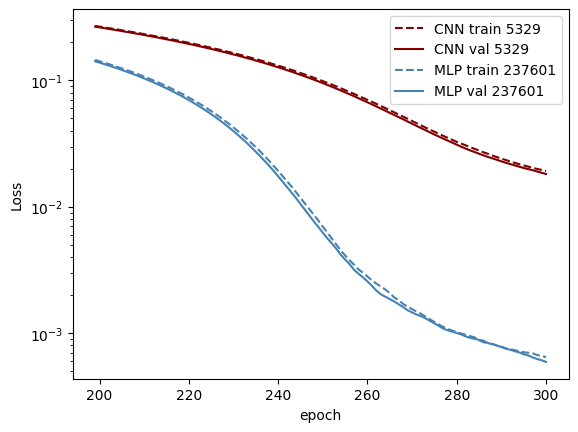

In [8]:
import pandas as pd

plt.plot(pd.DataFrame(traj_cnn[:,0]).rolling(200).mean(),label = f'CNN train {n_cnn}', c = 'maroon', linestyle = 'dashed')
plt.plot(pd.DataFrame(traj_cnn[:,1]).rolling(200).mean(),label = f'CNN val {n_cnn}', c = 'maroon', linestyle = 'solid')

plt.plot(pd.DataFrame(traj_mlp[:,0]).rolling(200).mean(),label = f'MLP train {n_mlp}', c = 'steelblue', linestyle = 'dashed')
plt.plot(pd.DataFrame(traj_mlp[:,1]).rolling(200).mean(),label = f'MLP val {n_mlp}', c = 'steelblue', linestyle = 'solid')
plt.legend()

plt.ylabel('Loss')
plt.xlabel('epoch')

plt.semilogy()

/var/folders/rv/8y6296jd7qdgdfvsp5qpxbx00000gn/T/ipykernel_51296/1098498701.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


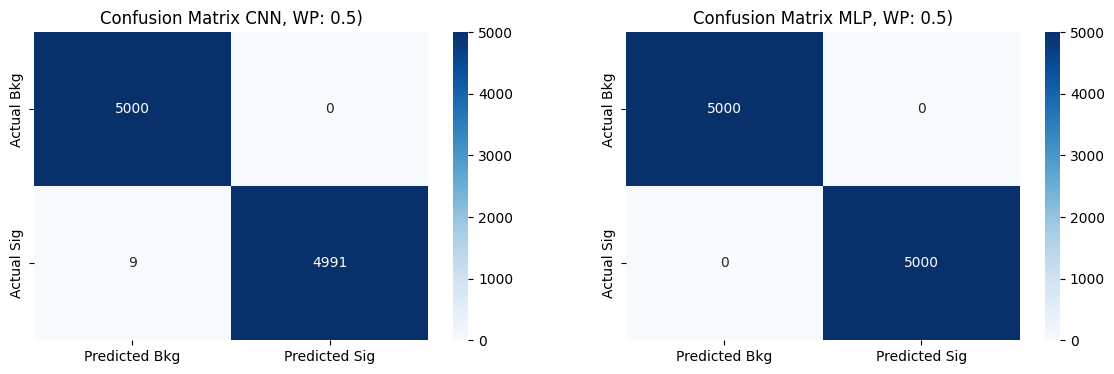

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

data_testing, true_labels = make_batch(N = 10000, collection='testing')
predicted_labels_cnn = trained_cnn(data_testing)
predicted_labels_mlp = trained_mlp(data_testing)

# Convert PyTorch tensors to NumPy arrays
true_labels = true_labels.cpu().numpy()
predicted_labels_cnn = predicted_labels_cnn.detach().numpy()
predicted_labels_mlp = predicted_labels_mlp.detach().numpy()
# Change the predicted labels into binary ones depending on WP
WP = 0.5
predicted_labels_cnn = np.array([(0. if i < WP else 1.) for i in predicted_labels_cnn])
predicted_labels_mlp = np.array([(0. if i < WP else 1.) for i in predicted_labels_mlp])


# Calculate the confusion matrix
confusion_matrix_result_cnn = confusion_matrix(true_labels, predicted_labels_cnn)
confusion_matrix_result_mlp = confusion_matrix(true_labels, predicted_labels_mlp)

# Plot the matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot the confusion matrix using seaborn
sns.heatmap(confusion_matrix_result_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Bkg', 'Predicted Sig'], yticklabels=['Actual Bkg', 'Actual Sig'], ax=ax1)
ax1.set_title(f'Confusion Matrix CNN, WP: {WP})')
sns.heatmap(confusion_matrix_result_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Bkg', 'Predicted Sig'], yticklabels=['Actual Bkg', 'Actual Sig'], ax=ax2)
ax2.set_title(f'Confusion Matrix MLP, WP: {WP})')

fig.show()